In [22]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import resample

In [2]:
data = pd.read_csv("C:\\Users\\LENOVO\\Downloads\\Online_Payments_Fraud_Detection.csv")
print(data.head())

   step      type    amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0     1   PAYMENT   9839.64  C1231006815       170136.0       160296.36   
1     1   PAYMENT   1864.28  C1666544295        21249.0        19384.72   
2     1  TRANSFER    181.00  C1305486145          181.0            0.00   
3     1  CASH_OUT    181.00   C840083671          181.0            0.00   
4     1   PAYMENT  11668.14  C2048537720        41554.0        29885.86   

      nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  
0  M1979787155             0.0             0.0        0               0  
1  M2044282225             0.0             0.0        0               0  
2   C553264065             0.0             0.0        1               0  
3    C38997010         21182.0             0.0        1               0  
4  M1230701703             0.0             0.0        0               0  


In [3]:
# Informations sur dataset
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB
None


In [4]:
# Distribution des classes
print(data['isFraud'].value_counts())

isFraud
0    6354407
1       8213
Name: count, dtype: int64


In [24]:
# Distribution des montants des transactions
plt.figure(figsize=(10, 5))
sns.histplot(data[data['isFraud'] == 1]['amount'], color='red', label='Frauduleuses', kde=True)
sns.histplot(data[data['isFraud'] == 0]['amount'], color='blue', label='Non frauduleuses', kde=True)
plt.title('Distribution des montants des transactions')
plt.xlabel('Montant des transactions')
plt.ylabel('Densité')
plt.legend()
# Enregistrement de la figure
plt.savefig('distribution_transactions.png')
plt.close()

In [6]:
# Équilibrage du jeu de données par suréchantillonnage des transactions frauduleuses
fraudulent_transactions = data[data['isFraud'] == 1]
non_fraudulent_transactions = data[data['isFraud'] == 0]
total_transactions_needed = len(non_fraudulent_transactions) * 10 // 9
fraudulent_count_needed = total_transactions_needed - len(non_fraudulent_transactions)

fraudulent_oversampled = resample(fraudulent_transactions,
                                  replace=True, 
                                  n_samples=fraudulent_count_needed, 
                                  random_state=42)

balanced_data = pd.concat([non_fraudulent_transactions, fraudulent_oversampled])
balanced_data = balanced_data.sample(frac=1, random_state=42).reset_index(drop=True)

print(balanced_data['isFraud'].value_counts())

isFraud
0    6354407
1     706045
Name: count, dtype: int64


In [7]:
# Vérification des valeurs manquantes
print(balanced_data.isnull().sum())

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64


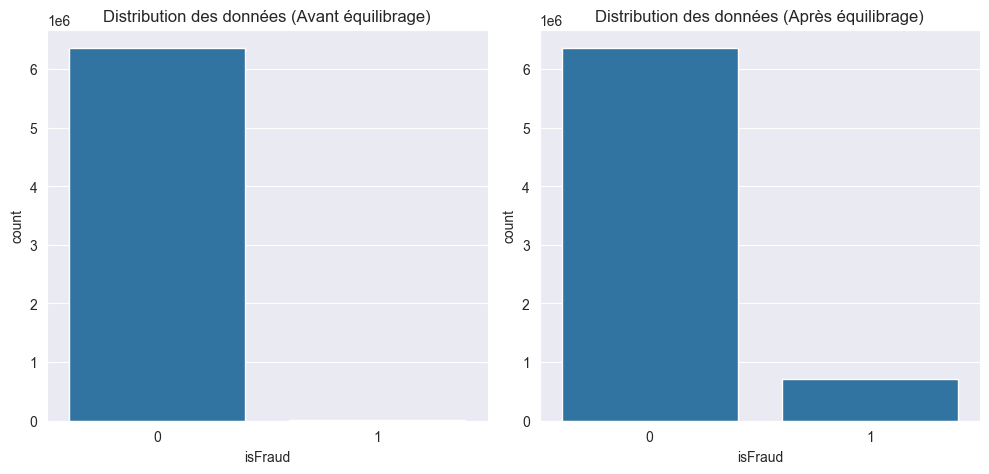

In [40]:
# Visualisation de la distribution avant et après équilibrage
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.countplot(x='isFraud', data=data)
plt.title('Distribution des données (Avant équilibrage)')
plt.subplot(1, 2, 2)
sns.countplot(x='isFraud', data=balanced_data)
plt.title('Distribution des données (Après équilibrage)')
plt.savefig('OverSampling.png')
plt.tight_layout()
plt.show()
plt.close()

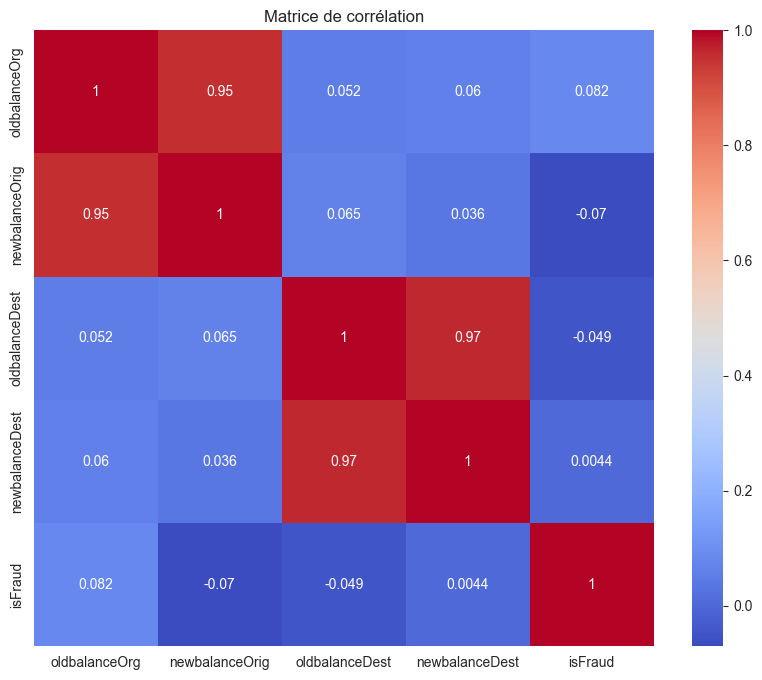

In [37]:
# Matrice de corrélation pour les caractéristiques numériques
numeric_balanced_data = balanced_data.select_dtypes(include=['number'])
correlation_matrix = numeric_balanced_data.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Matrice de corrélation')
plt.savefig('correlation_matrix.png') 
plt.show()



In [23]:
# Pairplot d'un petit échantillon de données équilibrées
small_sample = balanced_data.sample(n=1000, random_state=42)
small_sample['isFraud'] = small_sample['isFraud'].astype(str)
pairplot = sns.pairplot(small_sample, hue='isFraud', palette=['blue', 'red'])
pairplot.fig.suptitle('Caractéristiques par classe de fraude')
# Enregistrement de la figure
pairplot.savefig('pairplot_fraude.png')
plt.close()


In [11]:
# Sélection des features
balanced_data = balanced_data[['oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'isFraud']]
print(balanced_data.columns)

Index(['oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest',
       'isFraud'],
      dtype='object')


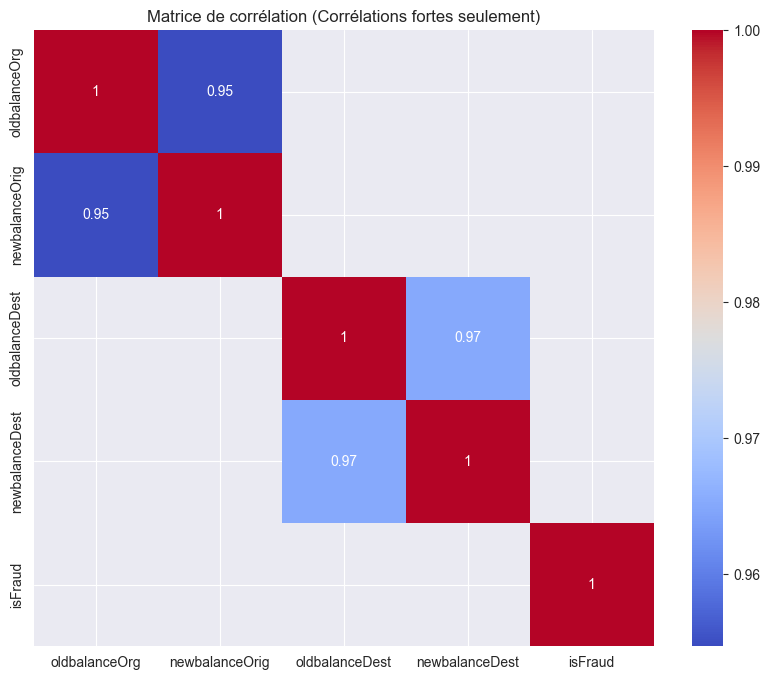

In [12]:
numeric_balanced_data = balanced_data.select_dtypes(include=['number'])
correlation_matrix = numeric_balanced_data.corr()
threshold = 0.8
strong_corr_matrix = correlation_matrix[(correlation_matrix >= threshold) | (correlation_matrix <= -threshold)]
mask = strong_corr_matrix.isnull()
plt.figure(figsize=(10, 8))
sns.heatmap(strong_corr_matrix, annot=True, cmap='coolwarm', mask=mask, cbar=True)
plt.title('Matrice de corrélation (Corrélations fortes seulement)')
plt.show()

In [13]:
# Split data into features and target variable for both balanced and unbalanced datasets
X_balanced = balanced_data.drop('isFraud', axis=1)
y_balanced = balanced_data['isFraud']

X_unbalanced = data.drop(['isFraud', 'type', 'nameOrig', 'nameDest', 'step'], axis=1)
y_unbalanced = data['isFraud']

# Division en ensembles d'entraînement et de test
X1_train, X1_test, y1_train, y1_test = train_test_split(X_balanced, y_balanced, test_size=0.25, random_state=1, stratify=y_balanced)
X2_train, X2_test, y2_train, y2_test = train_test_split(X_unbalanced, y_unbalanced, test_size=0.25, random_state=1, stratify=y_unbalanced)

In [14]:
# Fonction d'entraînement et de prédiction
def train_and_predict(model, X_train, y_train, X_test):
    model.fit(X_train, y_train)
    return model.predict(X_test)

In [15]:
# Modèles équilibrés
log_reg_balanced = LogisticRegression(solver='lbfgs', max_iter=500)
rf_balanced = RandomForestClassifier()

log_reg_pred_balanced = train_and_predict(log_reg_balanced, X1_train, y1_train, X1_test)
rf_pred_balanced = train_and_predict(rf_balanced, X1_train, y1_train, X1_test)

In [16]:
# Modèles non équilibrés
log_reg_unbalanced = LogisticRegression(solver='liblinear', max_iter=500)
rf_unbalanced = RandomForestClassifier()
log_reg_pred_unbalanced = train_and_predict(log_reg_unbalanced, X2_train, y2_train, X2_test)
rf_pred_unbalanced = train_and_predict(rf_unbalanced, X2_train, y2_train, X2_test)

In [17]:
# Fonction d'évaluation des modèles
def evaluate_model(predictions, y_test):
    metrics = {
        'Accuracy': accuracy_score(y_test, predictions),
        'Precision': precision_score(y_test, predictions, average='weighted'),
        'Recall': recall_score(y_test, predictions, average='weighted'),
        'F1 Score': f1_score(y_test, predictions, average='weighted')
    }
    return metrics

model_metrics = {
    'Logistic Regression (Équilibré)': evaluate_model(log_reg_pred_balanced, y1_test),
    'Random Forest (Équilibré)': evaluate_model(rf_pred_balanced, y1_test),
    'Logistic Regression (Non Équilibré)': evaluate_model(log_reg_pred_unbalanced, y2_test),
    'Random Forest (Non Équilibré)': evaluate_model(rf_pred_unbalanced, y2_test)
}

metrics_df = pd.DataFrame(model_metrics).T

# Affichage du DataFrame
print("Performance Metrics:")
print(metrics_df)

Performance Metrics:
                                     Accuracy  Precision    Recall  F1 Score
Logistic Regression (Équilibré)      0.964617   0.963524  0.964617  0.962508
Random Forest (Équilibré)            0.999549   0.999550  0.999549  0.999549
Logistic Regression (Non Équilibré)  0.997692   0.998860  0.997692  0.998157
Random Forest (Non Équilibré)        0.999566   0.999545  0.999566  0.999537


In [18]:
# Paramètres pour RandomizedSearchCV
param_grid = {
    'n_estimators': [50, 100], 
    'max_features': ['sqrt', 'log2', None],
    'max_depth': [6, 8, 10],
    'criterion': ['gini'],
    'max_leaf_nodes': [None, 6, 8],
    'min_samples_leaf': [1, 2],
    'min_samples_split': [2, 5]
}

# RandomizedSearchCV pour les données équilibrées
random_search_balanced = RandomizedSearchCV(estimator=RandomForestClassifier(), param_distributions=param_grid, n_iter=20, cv=3, verbose=4, random_state=42, n_jobs=-1)
random_search_balanced.fit(X1_train, y1_train)

# RandomizedSearchCV pour les données non équilibrées
random_search_unbalanced = RandomizedSearchCV(estimator=RandomForestClassifier(), param_distributions=param_grid, n_iter=20, cv=3, verbose=4, random_state=42, n_jobs=-1)
random_search_unbalanced.fit(X2_train, y2_train)

# Meilleurs hyperparamètres
best_params_balanced = random_search_balanced.best_params_
best_params_unbalanced = random_search_unbalanced.best_params_

print("Balanced", best_params_balanced)
print("Unbalanced", best_params_unbalanced)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Balanced {'n_estimators': 50, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_leaf_nodes': None, 'max_features': 'log2', 'max_depth': 10, 'criterion': 'gini'}
Unbalanced {'n_estimators': 50, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_leaf_nodes': None, 'max_features': 'log2', 'max_depth': 10, 'criterion': 'gini'}


In [19]:
# Entraînement de RandomForest avec les meilleurs hyperparamètres pour les données équilibrées
rf_balanced_hyper = RandomForestClassifier(**{'n_estimators': 50, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_leaf_nodes': None, 'max_features': 'log2', 'max_depth': 10, 'criterion': 'gini'})
rf_balanced_hyper.fit(X1_train, y1_train)
rf_pred_balanced_hyper = rf_balanced_hyper.predict(X1_test)

# Entraînement de RandomForest avec les meilleurs hyperparamètres pour les données non équilibrées
rf_unbalanced_hyper = RandomForestClassifier(**{'n_estimators': 50, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_leaf_nodes': None, 'max_features': 'log2', 'max_depth': 10, 'criterion': 'gini'})
rf_unbalanced_hyper.fit(X2_train, y2_train)
rf_pred_unbalanced_hyper = rf_unbalanced_hyper.predict(X2_test)

In [38]:
# Évaluation des modèles avec et sans hyperparamètres
model_metrics_hyper = {
    'Random Forest (Équilibré) avec Hyperparamètres': evaluate_model(rf_pred_balanced_hyper, y1_test),
    'Random Forest (Équilibré) sans Hyperparamètres': evaluate_model(rf_pred_balanced, y1_test),
    'Logistic Regression (Équilibré)': evaluate_model(log_reg_pred_balanced, y1_test),
    'Random Forest (Non Équilibré) avec Hyperparamètres': evaluate_model(rf_pred_unbalanced_hyper, y2_test),
    'Random Forest (Non Équilibré) sans Hyperparamètres': evaluate_model(rf_pred_unbalanced, y2_test),
    'Logistic Regression (Non Équilibré) ': evaluate_model(log_reg_pred_unbalanced, y2_test),
}

metrics_df_hyper = pd.DataFrame(model_metrics_hyper).T

# Enregistrement des métriques dans un fichier CSV
metrics_df_hyper.to_csv('model_metrics_hyper.csv')
print(metrics_df_hyper.to_string(index=True, justify='left'))

                                                    Accuracy  Precision  Recall    F1 Score
Random Forest (Équilibré) avec Hyperparamètres      0.982678  0.982445   0.982678  0.982241
Random Forest (Équilibré) sans Hyperparamètres      0.999549  0.999550   0.999549  0.999549
Logistic Regression (Équilibré)                     0.964617  0.963524   0.964617  0.962508
Random Forest (Non Équilibré) avec Hyperparamètres  0.999436  0.999423   0.999436  0.999364
Random Forest (Non Équilibré) sans Hyperparamètres  0.999566  0.999545   0.999566  0.999537
Logistic Regression (Non Équilibré)                 0.997692  0.998860   0.997692  0.998157


In [21]:
import joblib
joblib.dump(rf_balanced.fit(X1_train, y1_train), 'rf_model.pkl')

['rf_model.pkl']

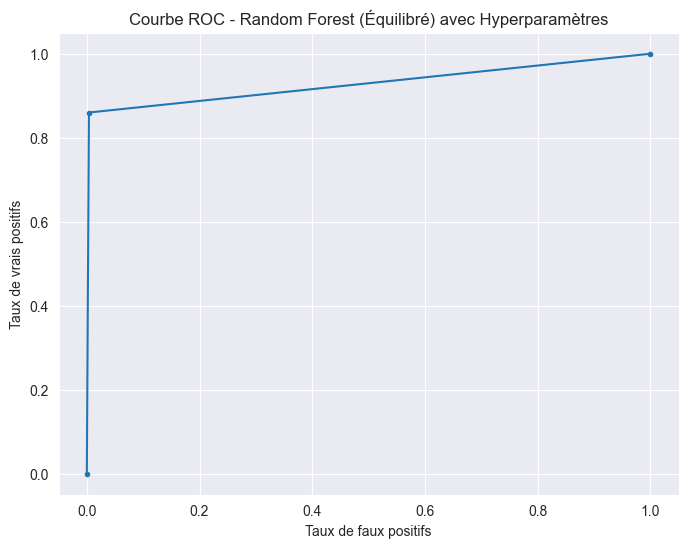

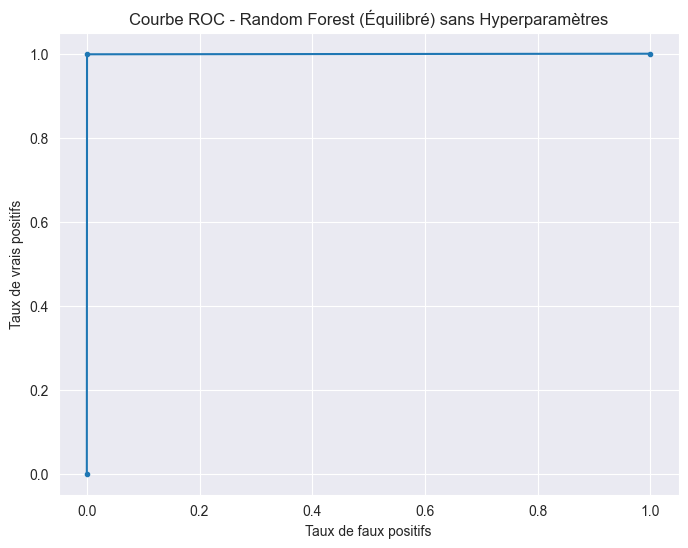

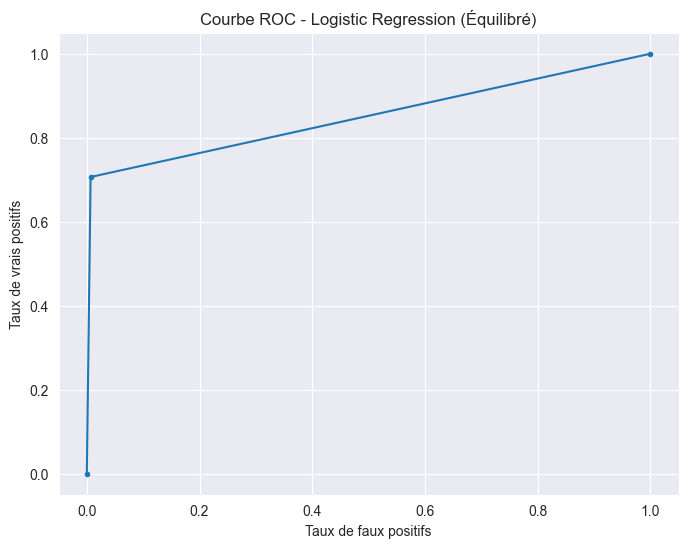

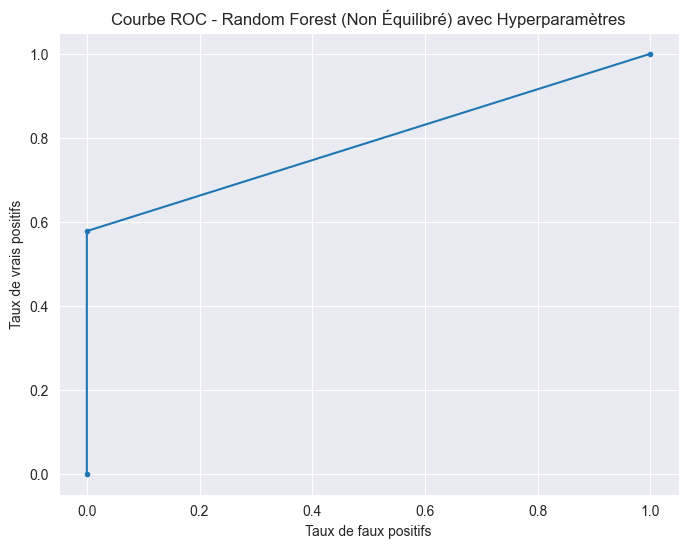

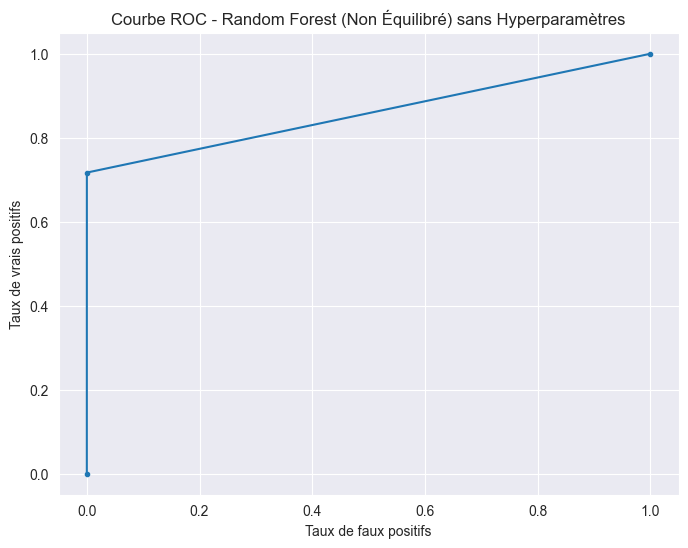

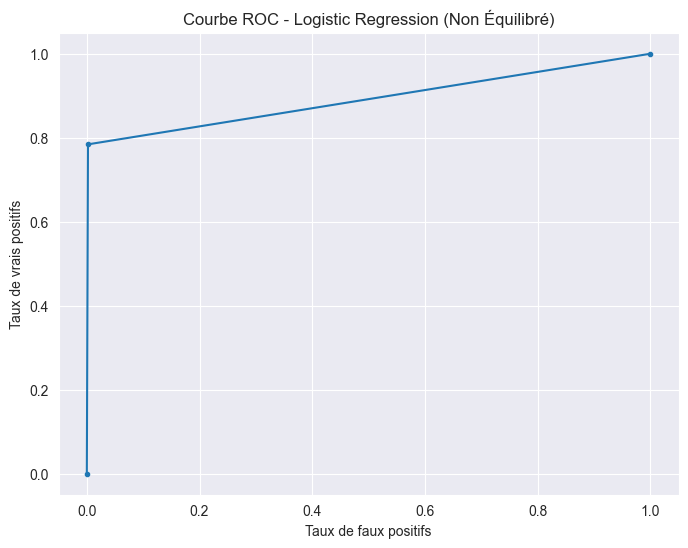

In [25]:
def plot_roc_curve(y_true, y_pred, title):
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, marker='.')
    plt.title(f'Courbe ROC - {title}')
    plt.xlabel('Taux de faux positifs')
    plt.ylabel('Taux de vrais positifs')
    plt.show()

# Afficher les courbes ROC
plot_roc_curve(y1_test, rf_pred_balanced_hyper, 'Random Forest (Équilibré) avec Hyperparamètres')
plot_roc_curve(y1_test, rf_pred_balanced, 'Random Forest (Équilibré) sans Hyperparamètres')
plot_roc_curve(y1_test, log_reg_pred_balanced, 'Logistic Regression (Équilibré)')
plot_roc_curve(y2_test, rf_pred_unbalanced_hyper, 'Random Forest (Non Équilibré) avec Hyperparamètres')
plot_roc_curve(y2_test, rf_pred_unbalanced, 'Random Forest (Non Équilibré) sans Hyperparamètres')
plot_roc_curve(y2_test, log_reg_pred_unbalanced, 'Logistic Regression (Non Équilibré)')

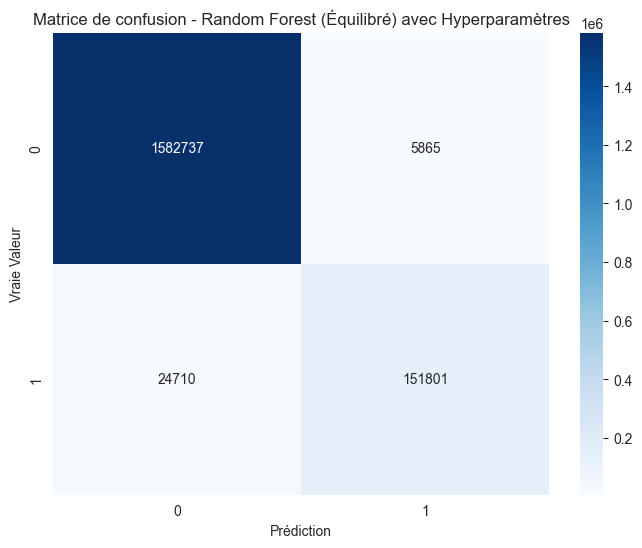

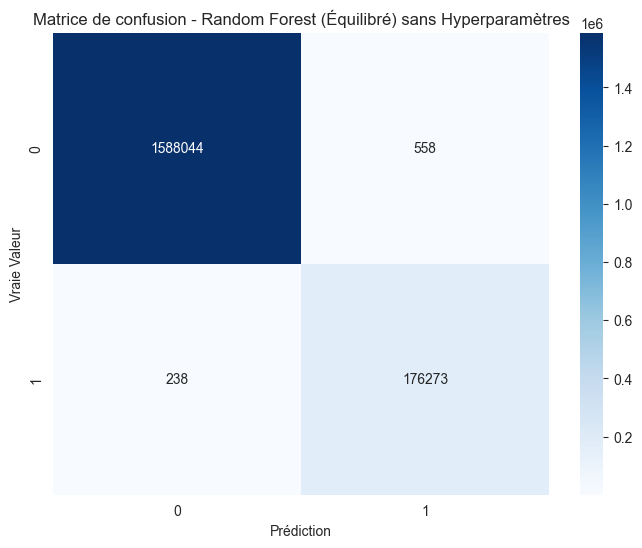

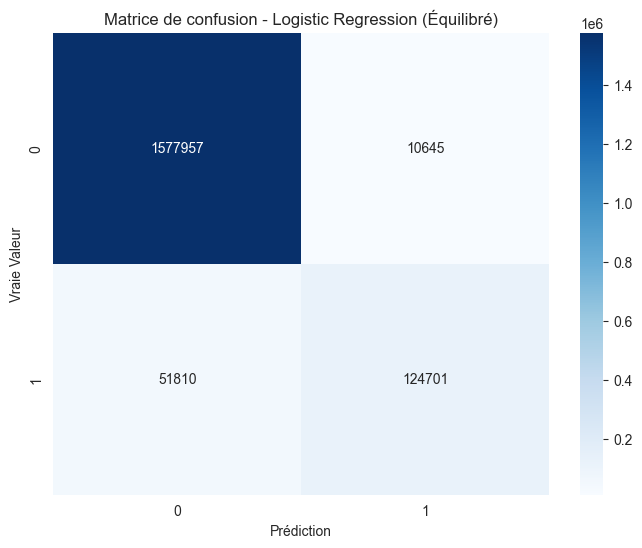

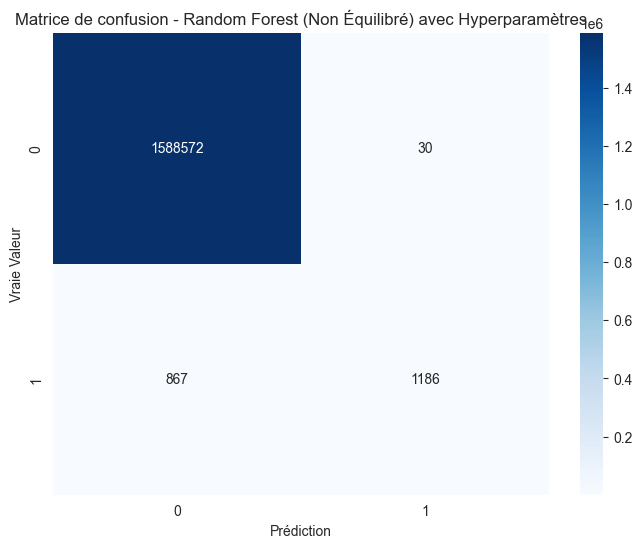

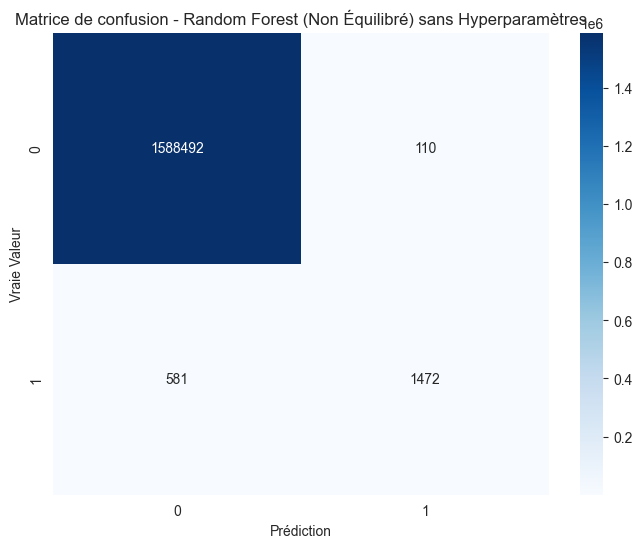

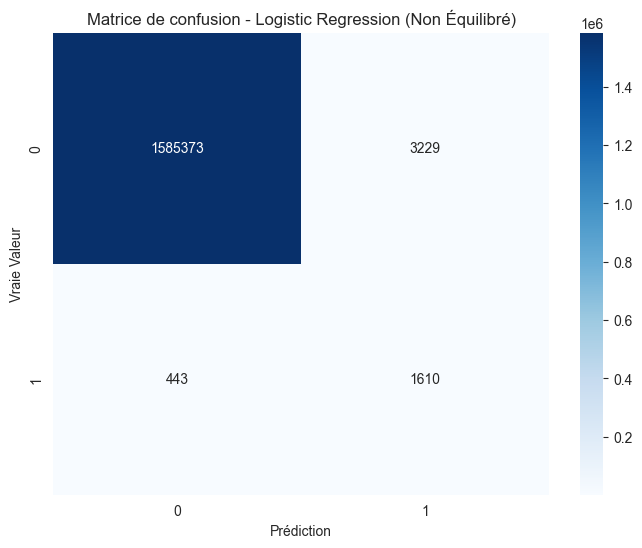

In [26]:
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Matrice de confusion - {title}')
    plt.xlabel('Prédiction')
    plt.ylabel('Vraie Valeur')
    plt.show()

# Afficher les matrices de confusion
plot_confusion_matrix(y1_test, rf_pred_balanced_hyper, 'Random Forest (Équilibré) avec Hyperparamètres')
plot_confusion_matrix(y1_test, rf_pred_balanced, 'Random Forest (Équilibré) sans Hyperparamètres')
plot_confusion_matrix(y1_test, log_reg_pred_balanced, 'Logistic Regression (Équilibré)')
plot_confusion_matrix(y2_test, rf_pred_unbalanced_hyper, 'Random Forest (Non Équilibré) avec Hyperparamètres')
plot_confusion_matrix(y2_test, rf_pred_unbalanced, 'Random Forest (Non Équilibré) sans Hyperparamètres')
plot_confusion_matrix(y2_test, log_reg_pred_unbalanced, 'Logistic Regression (Non Équilibré)')
